# Import libraries and dataframe

In [250]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import plot_confusion_matrix, f1_score
from scoring_functions import scoring_functions as f

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression


# imp allows to reload the above function file when tinkering with it without kernel restart
import imp

import matplotlib.pyplot as plt

In [251]:
df = pd.read_csv('complaints_processed_1year_0719.csv')


In [264]:
# df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['processed narrative'].isnull().sum()
df = df.dropna()

## Change product names to integers

In [265]:
df['product'].unique()

array([1, 0])

In [266]:
df['product'].value_counts()

0    49399
1     1236
Name: product, dtype: int64

In [267]:
product_dict ={'Non Money Transfer': 0, 'Money Transfer': 1}

In [268]:
df['product'].replace(product_dict, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [269]:
df['product'].unique()

array([1, 0])

In [270]:
df['product'].value_counts()

0    49399
1     1236
Name: product, dtype: int64

In [271]:
df.head()

,product,narrative,processed narrative
0,1,My wife received settlement from XXXX XXXX com...,wife received settlement company amount opted ...
1,1,My girlfriend sent me {$5000.00} on XX/XX/XXXX...,girlfriend sent using paypal help pay work don...
2,1,"On XX/XX/2021, I initiated a wire transfer of ...",initiated wire transfer gemini account externa...
3,1,Can not link my PNC Bank account to numerous X...,link pnc bank account numerous platform
4,1,I receive two payment for the amount of {$1500...,receive two payment amount cash app try cash m...


# Train-test split

In [272]:
X = df.drop(['product'], axis=1)
y = df['product']
X = X['processed narrative']
vect_y_train = y

In [273]:
vect_y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: product, dtype: int64

### CountVector

In [274]:
# CountVector
vectorizer = CountVectorizer(ngram_range=(2,3),stop_words = 'english', min_df = 2, max_features = 5000)
vect_X_train = vectorizer.fit_transform(X)
feature_names =  vectorizer.get_feature_names()
print(len(feature_names))

5000


In [ ]:
import time
start = time.time()

pipe = Pipeline([('CountVect', CountVectorizer(stop_words='english',
                                              ngram_range=(2, 3), max_features = 5000)),
                   ('clf', LogisticRegression(random_state=0, 
                                              fit_intercept=False, max_iter = 5000))
                    ])
                 
param_grid = {'CountVect__min_df': [2, 5, 10],
              'clf__C': np.logspace(-3,3,7),
              'clf__penalty': ['l1', 'l2'],
              'clf__solver': ['liblinear', 'newton-cg', 'lbfgs'],
             } 
# param_grid = {'CountVect__max_features': [1000,2000, 3000, 4000, 5000],
#               'CountVect__min_df': [2, 5, 10],
#               'clf__C': np.logspace(-3,3,7),
#               'clf__penalty': ['l1', 'l2'],
#               'clf__solver': ['liblinear', 'newton-cg', 'lbfgs'],
#               'clf__max_iter': [1000, 5000, 10000]
#              } 
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs = -1)

grid_countvect = grid.fit(X, y)

end=time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))



In [243]:
grid_countvect.best_params_

{'CountVect__min_df': 2,
 'clf__C': 0.01,
 'clf__penalty': 'l2',
 'clf__solver': 'liblinear'}

In [245]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)
pipe = Pipeline([('CountVect', CountVectorizer(stop_words='english',
                                              ngram_range=(2, 3), min_df = 2, max_features=5000)),
                   ('clf', LogisticRegression(penalty = 'l2', C=0.01, solver = 'liblinear', random_state=0, 
                                              fit_intercept=False, max_iter=5000))
                    ])
model_lr = pipe.fit(X_train, y_train)

In [246]:
def proba_to_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [247]:
df_test = pd.read_csv('complaints_processed_1year_0719_test.csv')
df_test.drop(['Unnamed: 0'], axis=1, inplace=True)
df_test.head()
if df_test['processed narrative'].isnull().sum() != 0:
    df_test = df_test.dropna()
df_test['processed narrative'].isnull().sum()


0

In [248]:
from sklearn.metrics import precision_recall_curve
from numpy import argmax
import matplotlib.pyplot as plt


df_test = pd.read_csv('complaints_processed_1year_0719_test.csv')
df_test.drop(['Unnamed: 0'], axis=1, inplace=True)
if df_test['processed narrative'].isnull().sum() != 0:
    df_test = df_test.dropna()
df_test['processed narrative'].isnull().sum()
product_dict ={'Non Money Transfer': 0, 'Money Transfer': 1}
df_test['product'].replace(product_dict, inplace=True)
print(df_test['product'].value_counts())
X_test = df_test['processed narrative']
y_test = df_test['product']

pred_proba = model_lr.predict_proba(X_val)

pred_proba_class_1 = pred_proba[:,1]

precision, recall, thresholds = precision_recall_curve(y_val, pred_proba_class_1)

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)

0    181687
1      4944
Name: product, dtype: int64
Best Threshold=0.500867, F-Score=0.926


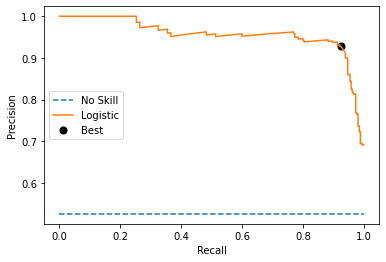

In [249]:
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best', s = 50)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()


In [ ]:
print(thresholds[ix])
pred_proba_test = model_lr.predict_proba(X_test)
pred_proba_test_class_1 = pred_proba_test[:, 1]
y_hat = proba_to_classes(pred_proba_test_class_1, thresholds[ix])
print(f1_score(y_test, y_hat))
# predict_proba = model_lr.predict_proba

In [222]:
FNs_pred_proba = []
pred_neg = []
for index, (label, label_hat) in enumerate(zip(y_test, y_hat)):
    if label == 1 and label_hat == 0:
        FNs_pred_proba.append(pred_proba_test_class_1[index])
    if label_hat == 0:
        pred_neg.append(pred_proba_test_class_1[index])
        

[  3.   2.  13.  41. 351.]
[20869. 20996. 30767. 24818. 61656.]
[1.43753893e-04 9.52562393e-05 4.22530633e-04 1.65202675e-03
 5.69287661e-03]


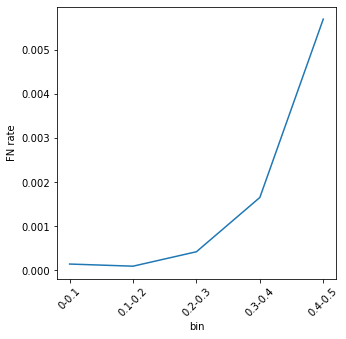

In [223]:
FNn, bins, _ = plt.hist(FNs_pred_proba, bins=5, range = [0,0.5])
print(FNn)
pred_Nn, _, _ = plt.hist(pred_neg, bins=5, range = [0,0.5])
print(pred_Nn)
FN_rate = np.divide(np.array(FNn), np.array(pred_Nn))
print(FN_rate)
plt.close()
plt.figure(figsize = (5, 5))
plt.plot(FN_rate)
plt.xticks(np.arange(5), ["0-0.1", 
                          "0.1-0.2", 
                          "0.2-0.3", 
                          "0.3-0.4", 
                          "0.4-0.5"],
                        rotation=45)
#                           "0.5-0.6", 
#                           "0.6-0.7", 
#                           "0.7-0.8"],

plt.ylabel('FN rate')
plt.xlabel('bin')
plt.show()

In [224]:
FN_rate

array([1.43753893e-04, 9.52562393e-05, 4.22530633e-04, 1.65202675e-03,
       5.69287661e-03])

### TF-IDF

In [225]:
pipe = Pipeline([('TfidfVect', TfidfVectorizer(stop_words='english',
                                              ngram_range=(2, 3), max_features = 5000)),
                   ('clf', LogisticRegression(random_state=0, 
                                              fit_intercept=False))
                    ])

param_grid = {
              'TfidfVect__min_df': [2, 5, 10],
              'clf__C': np.logspace(-3,3,7),
              'clf__penalty': ['l1', 'l2'],
              'clf__solver': ['liblinear', 'newton-cg', 'lbfgs'],
              'clf__max_iter': [1000, 5000, 10000]
             } 
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs = -1)

grid_tfidf = grid.fit(X_train, y)


%%time

ValueError: Found input variables with inconsistent numbers of samples: [2013, 2517]

scipy.sparse._csr.csr_matrix

In [60]:
# train logistic regression model

In [127]:
from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(penalty='l1', solver='liblinear', random_state=0, fit_intercept=False, max_iter = 10000).fit(vect_X_train, y_train)
clf = LogisticRegression(random_state=0, fit_intercept=False, max_iter = 10000).fit(vect_X_train, y_train)

# clf.predict(vect_X_train)

In [128]:
train_y_pred_proba = clf.predict_proba(vect_X_train)
train_y_predict_prob_class_1 = train_y_pred_proba[:,1]
train_y_predict_class = [1 if train_y_predict_prob_class_1[i] > 0.96 else 0 for i in range(len(train_y_predict_prob_class_1))]

In [129]:
f'The accuracy score is: {round(accuracy_score(y_train, train_y_predict_class)*100, 2)}%'

'The accuracy score is: 94.28%'

Accuracy: 94.3%
Precision: 96.8%
Recall: 81.8%
F1: 87.2%


Classification Report


              precision    recall  f1-score   support

           0       0.94      1.00      0.97     77516
           1       1.00      0.64      0.78     14423

    accuracy                           0.94     91939
   macro avg       0.97      0.82      0.87     91939
weighted avg       0.95      0.94      0.94     91939



/Users/keqiaoli/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


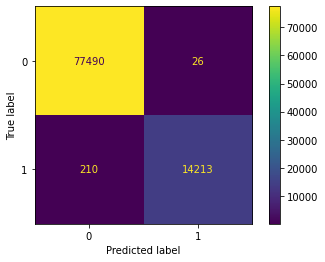

In [130]:
imp.reload(f)
f.scoring(y_train, train_y_predict_class, clf, vect_X_train)

# Run model on Validation dataset

In [131]:
val_pred_proba = clf.predict_proba(vect_X_val)

In [132]:
val_y_predict_prob_class_1 = val_pred_proba[:,1]

In [135]:
val_y_predict_class = [1 if val_y_predict_prob_class_1[i] > 0.96 else 0 for i in range(len(val_y_predict_prob_class_1))]

In [136]:
len(y_predict_class)

22985

Accuracy: 92.4%
Precision: 94.4%
Recall: 76.5%
F1: 82.2%


Classification Report


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     19393
           1       0.97      0.53      0.69      3592

    accuracy                           0.92     22985
   macro avg       0.94      0.77      0.82     22985
weighted avg       0.93      0.92      0.91     22985



/Users/keqiaoli/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


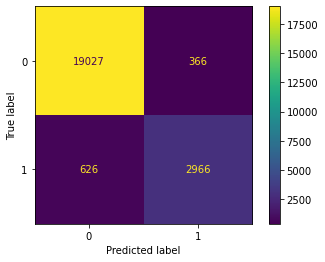

In [137]:
f.scoring(y_val, val_y_predict_class, clf, vect_X_val)

In [138]:
FN_pred_prob = [y_predict_prob_class_1[i] if y_predict_prob_class_1[i] < 0.96 else 0 for i in range(len(y_predict_prob_class_1))]

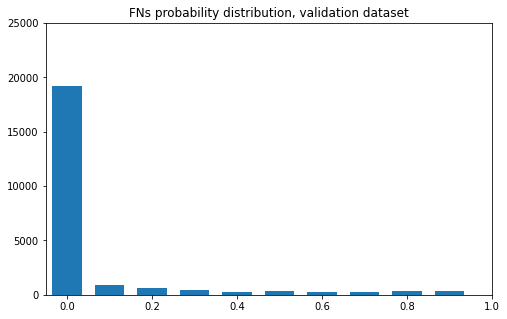

In [144]:
plt.figure(figsize = (8, 5))
plt.hist(FN_pred_prob, bins=10, range = [0,1], rwidth=0.7, align='left')
plt.xlim(-0.05,1)
plt.ylim(0, 25000)
plt.title('FNs probability distribution, validation dataset')
plt.show()

Accuracy: 92.2%
Precision: 94.2%
Recall: 76.1%
F1: 81.8%


Classification Report


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     24191
           1       0.97      0.53      0.68      4540

    accuracy                           0.92     28731
   macro avg       0.94      0.76      0.82     28731
weighted avg       0.93      0.92      0.91     28731



/Users/keqiaoli/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


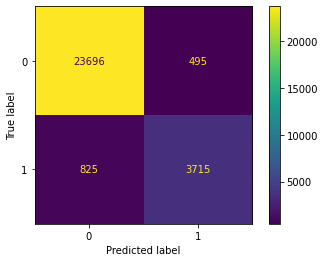

In [140]:
test_pred_proba = clf.predict_proba(vect_X_test)
test_y_predict_prob_class_1 = test_pred_proba[:,1]
test_y_predict_class = [1 if test_y_predict_prob_class_1[i] > 0.96 else 0 for i in range(len(test_y_predict_prob_class_1))]
f.scoring(y_test, test_y_predict_class, clf, vect_X_test)

In [141]:
test_FN_pred_prob = [test_y_predict_prob_class_1[i] if test_y_predict_prob_class_1[i] < 0.96 else 0 for i in range(len(test_y_predict_prob_class_1))]

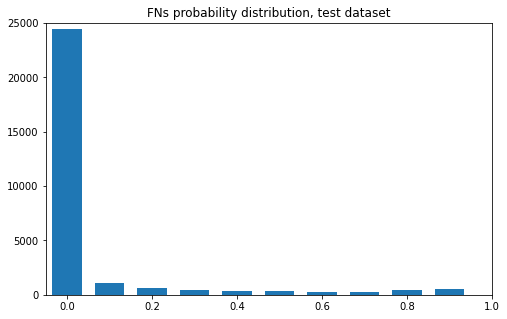

In [143]:
plt.figure(figsize = (8, 5))
plt.hist(test_FN_pred_prob, bins=10, range = [0,1], rwidth=0.7, align='left')
plt.xlim(-0.05,1)
plt.ylim(0, 25000)
plt.title('FNs probability distribution, test dataset')
plt.show()